# Building A Spam Filter With Naive Bayes

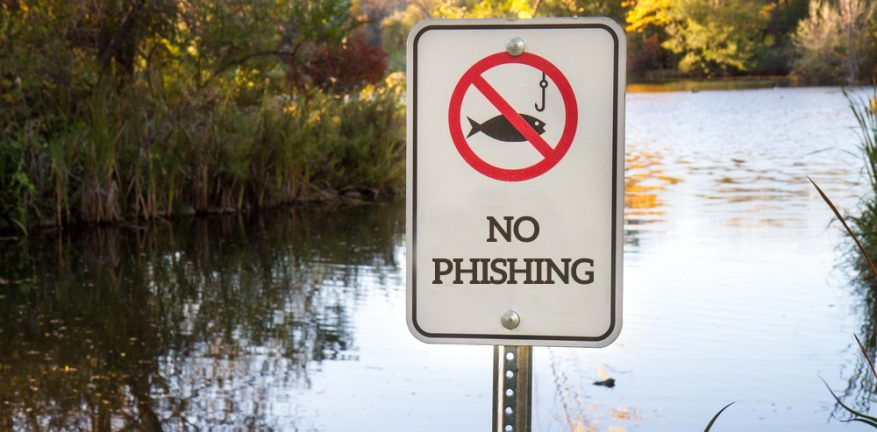

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1">Introduction</a></span><ul class="toc-item"><li><span><a href="#Results" data-toc-modified-id="Results-1.1">Results</a></span></li></ul></li><li><span><a href="#Data-Exploration" data-toc-modified-id="Data-Exploration-2">Data Exploration</a></span></li><li><span><a href="#Creating-A-Training-And-Testing-Set" data-toc-modified-id="Creating-A-Training-And-Testing-Set-3">Creating A Training And Testing Set</a></span></li><li><span><a href="#Data-Preparation" data-toc-modified-id="Data-Preparation-4">Data Preparation</a></span><ul class="toc-item"><li><span><a href="#Data-Normalization" data-toc-modified-id="Data-Normalization-4.1">Data Normalization</a></span></li><li><span><a href="#Building-the-Vocabulary" data-toc-modified-id="Building-the-Vocabulary-4.2">Building the Vocabulary</a></span></li><li><span><a href="#Transforming-the-Dataset" data-toc-modified-id="Transforming-the-Dataset-4.3">Transforming the Dataset</a></span></li></ul></li><li><span><a href="#Calculating-Constants" data-toc-modified-id="Calculating-Constants-5">Calculating Constants</a></span><ul class="toc-item"><li><span><a href="#Calculating-P(Spam)-and-P(ham)" data-toc-modified-id="Calculating-P(Spam)-and-P(ham)-5.1">Calculating P(Spam) and P(ham)</a></span></li><li><span><a href="#Calculating-Number-of-Words-in-Spam,-Ham-and-Vocabulary" data-toc-modified-id="Calculating-Number-of-Words-in-Spam,-Ham-and-Vocabulary-5.2">Calculating Number of Words in Spam, Ham and Vocabulary</a></span></li></ul></li><li><span><a href="#Calculating-Parameters" data-toc-modified-id="Calculating-Parameters-6">Calculating Parameters</a></span></li><li><span><a href="#Creating-the-Spam-Filter" data-toc-modified-id="Creating-the-Spam-Filter-7">Creating the Spam Filter</a></span></li><li><span><a href="#Measuring-Accuracy" data-toc-modified-id="Measuring-Accuracy-8">Measuring Accuracy</a></span></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-9">Conclusion</a></span></li></ul></div>

## Introduction
In this project our task is to use the Naive Bayes algorithm to teach a computer to classify text messages as spam. Spam is any kind of unwanted, unsolicited digital communication that gets sent in bulk. To classify a message as spam or non-spam, a computer will need to:
1) Learn how humans classify messages.  
2) Use that human knowledge to estimate probabilities for new messages - probabilities for spam and non-spam.  
3) Classify a new message based on these probability values

To train our algorithm we will use a dataset of 5,572 pre-classified (spam vs non-spam) text messages. The dataset can be downloaded from [The UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/sms+spam+collection).

Our goal is to create an algorithm with at least an 80% classification accuracy.

### Results
Our result was an algorithm that could classify new messages with 97% accuracy.

One successful action we took in refining our algorithm was to encode characters and patterns as words, such as punctuation and phone numbers. By doing this we were able to increase our algorithm's accuracy by 1%. The most impactful measure was the __business_phone__ encoding.

Possible next steps are to further encode characters and patters so that they contribute to the algorithm's consideration set rather than being removed.

## Data Exploration
Let's get a feel for the dataset and address any necessary data preparation steps.

In [1]:
# read in the dataset
import re
import pandas as pd
pd.options.display.max_colwidth = 10000000
pd.options.display.max_columns= 1000

sms = pd.read_csv('SMSSpamCollection', sep = '\t', header = None)

In [2]:
sms.head()

,0,1
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives around here though"


The dataset does not have headers. The first column appears to be the classification of the text and the second column is the text message itself. Let's rename these now.

In [3]:
# give the columns names
sms.columns = ['Label', 'SMS']
sms.head()

,Label,SMS
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives around here though"


Let's explore the data further. 

In [4]:
sms.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Label   5572 non-null   object
 1   SMS     5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [5]:
sms['Label'].value_counts(normalize = True)

ham     0.865937
spam    0.134063
Name: Label, dtype: float64

There are 5,572 rows of text message data, of which there are no null values. The dataset is composed entirely of string datatypes, our first column is nominal data that represent two categorizations spam and ham ([ham is a shorthand for non-spam](https://cwiki.apache.org/confluence/display/spamassassin/Ham) and the other column is string values of each categorized message. 87% of our text messages are classified as non-spam and 13% are spam.

## Creating A Training And Testing Set

Before we move on to creating our algorithm, it will be good practice to set up our project so that we can test whether our algorithm can accurately classify text messages. To do this we will split our data into two categories:
* A training set, which we'll use to "train" the computer how to classify the messages.
* A test set, which we'll use to test how good the spam filter is at classifying new messages.

We're going to keep 80% of our dataset for training, and 20% for testing. Once our algorithm is trained, we will treat the 20% of text messages as new, meaning our algorithm will not take into consideration that the messages were previously classified by a human being. Once our algorithm has done its own classification we will then compare its efficacy through comparison with the human classification. 

Let's segment our data now.

In [6]:
# show the number of messages in each category
sms['Label'].value_counts()

ham     4825
spam     747
Name: Label, dtype: int64

We have 5,572 messages total and two categories of messages to consider. Most of our messages are not spam, however. When we create our training dataset and out testing datasets it will be a good practice to keep the two datasets proportional in their represtivity while also maintaining randomness in selection. All this means is that we want to make sure that both our training dataset and testing dataset maintain the 87% non-spam and 13% spam proportionality. To accomplish this we will use proportional stratified sampling.

In [7]:
#randomize our data
sms_randomized = sms.sample(frac=1,random_state=1) # frac randomizes the entire dataset inplace of itself

# split our data by ham and spam
ham = sms_randomized[sms_randomized['Label'] == 'ham']
spam = sms_randomized[sms_randomized['Label'] == 'spam']

# split ham by training and testing set 
ham_training = ham[:(round(len(ham)*.8))]
ham_testing = ham[(round(len(ham)*.8)):]

# split spam by training and testing set
spam_training = spam[:(round(len(spam)*.8))]
spam_testing = spam[(round(len(spam)*.8)):]

# create combined testing and combined training datasets
sms_training = pd.concat([ham_training, spam_training], axis = 0).sample(frac=1,random_state=1).reset_index(drop=True)
sms_test = pd.concat([ham_testing,spam_testing], axis = 0).sample(frac=1,random_state=1).reset_index(drop=True)

# show the count of rows in each
print('actual training:',sms_training.shape)
print('actual testing:',sms_test.shape)

actual training: (4458, 2)
actual testing: (1114, 2)


In [8]:
# show the expected split
print('exptected training:', round(5572*.8))
print('execteded testing:', round(5572*.2))

exptected training: 4458
execteded testing: 1114


In [9]:
# show test set distribution
sms_test['Label'].value_counts(normalize = True)

ham     0.866248
spam    0.133752
Name: Label, dtype: float64

In [10]:
# show training set distribution
sms_training['Label'].value_counts(normalize = True)

ham     0.865859
spam    0.134141
Name: Label, dtype: float64

We now have two datasets split randomly into a testing and training set with representative proportions of categorization labels.

## Data Preparation

We will need to break down the sentences into their individual parts (words) and count the frequency of occurence that a word occurs in a given sentence. To do this we will need to build a vocabulary of distinct words that occur throughout the dataset, then loop through each sentence counting the frequency with which each word occurs. This will put our data in a format that can be properly fed into a Naive Bayes algorithm. 

Let's start with normalizing our dataset and building our vocabulary. 

### Data Normalization
We aren't generally interested in punctuation and letter case, however, there are circumstances that may be more indicative to a business making an offer (spam) or inversely of friendly communication patterns (not spam). For example, a semicolon usually precludes an offer being made with several options present, while an elipsis may be indicative of normal texting behaviors that person's of certain age groups are more likely to use. After running through this project we've refined which punctuation we're interested in keeping and encoding and were able to increase our accuracy by 1% by adding these extra normalization steps. 

Let's explore our data now and take steps to normalize it.

In [11]:
# show the data before removing punctuation and case
sms_training.head()

,Label,SMS
0,ham,U're welcome... Caught u using broken english again...
1,ham,Yes. Nigh you cant aha.
2,ham,If u laugh really loud.. If u talk spontaneously.. If u dont care what others feel.. U are probably with your dear &amp; best friends.. GOODEVENING Dear..:)
3,spam,Sunshine Quiz! Win a super Sony DVD recorder if you canname the capital of Australia? Text MQUIZ to 82277. B
4,ham,"Haha get used to driving to usf man, I know a lot of stoners"


In [12]:
sms_training.tail()

,Label,SMS
4453,ham,That sucks. I'll go over so u can do my hair. You'll do it free right?
4454,ham,Senthil group company Apnt 5pm.
4455,ham,HI BABE U R MOST LIKELY TO BE IN BED BUT IM SO SORRY ABOUT TONIGHT! I REALLY WANNA SEE U TOMORROW SO CALL ME AT 9. LOVE ME XXX
4456,spam,"Got what it takes 2 take part in the WRC Rally in Oz? U can with Lucozade Energy! Text RALLY LE to 61200 (25p), see packs or lucozade.co.uk/wrc & itcould be u!"
4457,ham,Where at were hungry too


In [13]:
# regex patterns that will capture patterns we want to keep
business_phone = r"([0-9]{5}?)"
money_sign = r"([\$])"
euro_sign = r"([\£])"
semi_colon = r"([\:])"
exclamation_point = r"([\!])"
repeating_exclamation = r"([\!]{2,})"
elipsis = r"([\.]{2,})"
repeating_question = r"([\?]{2,})"

# replace the patterns with pure text that won't be removed
sms_training['SMS'] = sms_training['SMS'].str.replace("'","").str.replace(business_phone, "__business_phone__").str.replace(money_sign, " __money_sign__ ").str.replace(euro_sign, " __euro_sign__ ").str.replace(semi_colon, " __semi_colon__ ").str.replace(exclamation_point, " __exclamation_point__ ").str.replace(repeating_exclamation, " __repeating_exclamation__ ").str.replace(elipsis, " __elipsis__ ").str.replace(repeating_question, " __repeating_question__ ")

In [14]:
# replace anything that is not a number or a-z and turn everything to lowercase
sms_training['SMS'] = sms_training['SMS'].str.replace(r'\W',' ').str.replace("  "," ").str.lower()

sms_training.head()

,Label,SMS
0,ham,ure welcome __elipsis__ caught u using broken english again __elipsis__
1,ham,yes nigh you cant aha
2,ham,if u laugh really loud __elipsis__ if u talk spontaneously __elipsis__ if u dont care what others feel __elipsis__ u are probably with your dear amp best friends __elipsis__ goodevening dear __elipsis__ __semi_colon__
3,spam,sunshine quiz __exclamation_point__ win a super sony dvd recorder if you canname the capital of australia text mquiz to __business_phone__ b
4,ham,haha get used to driving to usf man i know a lot of stoners


In [15]:
sms_training.tail()

,Label,SMS
4453,ham,that sucks ill go over so u can do my hair youll do it free right
4454,ham,senthil group company apnt 5pm
4455,ham,hi babe u r most likely to be in bed but im so sorry about tonight __exclamation_point__ i really wanna see u tomorrow so call me at 9 love me xxx
4456,spam,got what it takes 2 take part in the wrc rally in oz u can with lucozade energy __exclamation_point__ text rally le to __business_phone__ 25p see packs or lucozade co uk wrc itcould be u __exclamation_point__
4457,ham,where at were hungry too


Our changes were successful.

### Building the Vocabulary
We want to count the occurence of every possible word in each sentence. To do that we will need a list of distinct words that have been sent in our test set. 

First we need to turn each sentence into list of words. Then we will need to loop over each list and add each word to a master list. Finally, we will need to remove any duplicate word occurences from the master list. 

Let's follow the above steps and create our list of vocabulary words.

In [16]:
# turn each text message from a sentence to a list of words
sms_training['word_list'] = sms_training['SMS'].str.split()

sms_training.head()

,Label,SMS,word_list
0,ham,ure welcome __elipsis__ caught u using broken english again __elipsis__,"[ure, welcome, __elipsis__, caught, u, using, broken, english, again, __elipsis__]"
1,ham,yes nigh you cant aha,"[yes, nigh, you, cant, aha]"
2,ham,if u laugh really loud __elipsis__ if u talk spontaneously __elipsis__ if u dont care what others feel __elipsis__ u are probably with your dear amp best friends __elipsis__ goodevening dear __elipsis__ __semi_colon__,"[if, u, laugh, really, loud, __elipsis__, if, u, talk, spontaneously, __elipsis__, if, u, dont, care, what, others, feel, __elipsis__, u, are, probably, with, your, dear, amp, best, friends, __elipsis__, goodevening, dear, __elipsis__, __semi_colon__]"
3,spam,sunshine quiz __exclamation_point__ win a super sony dvd recorder if you canname the capital of australia text mquiz to __business_phone__ b,"[sunshine, quiz, __exclamation_point__, win, a, super, sony, dvd, recorder, if, you, canname, the, capital, of, australia, text, mquiz, to, __business_phone__, b]"
4,ham,haha get used to driving to usf man i know a lot of stoners,"[haha, get, used, to, driving, to, usf, man, i, know, a, lot, of, stoners]"


In [17]:
# create an empty list for our vocabulary words
vocabulary = []

for row in sms_training['word_list']:
    for word in row:
        if word not in vocabulary:
            vocabulary.append(word)   
            
print(len(vocabulary))
print(vocabulary[:10])

7559
['ure', 'welcome', '__elipsis__', 'caught', 'u', 'using', 'broken', 'english', 'again', 'yes']


We have 7,559 words (and representations) in our vocabulary training dataset. 

### Transforming the Dataset
We want the dataset in a format where each column represents the occurence of a word in each message (row). It will look something like the below table.

 Index | Label | ure | welcome| __elipsis__ | ...
-----|-----|-----|-----|-----|-----|
0|ham|1|1|2|...|
1|ham|0|0|0|...|
2|ham|0|0|5|...|
3|spam|0|0|0|...|
...|...|...|...|...|...|

Let's create that now.

In [18]:
# create empty dictionary - key is word from vocab - val is length of training set
# this creates a list of 0's equal to the number of rows of sms for each word (key) in the vocab
word_counts_per_sms = {unique_word: [0]*len(sms_training['word_list']) for unique_word in vocabulary}

# modify the dictionary by looping over each wordlist and increment by one for each occurence
for index, sms in enumerate(sms_training['word_list']): # enumerate grabs both the message and the index 
    for word in sms: # loops over each word in each message
        word_counts_per_sms[word][index] += 1 # the index tells the code the depth it needs to += for that word

# transform the dictionary into a dataframe
word_counts = pd.DataFrame(word_counts_per_sms)

print(word_counts.head())

   ure  welcome  __elipsis__  caught  u  using  broken  english  again  yes  \
0    1        1            2       1  1      1       1        1      1    0   
1    0        0            0       0  0      0       0        0      0    1   
2    0        0            5       0  4      0       0        0      0    0   
3    0        0            0       0  0      0       0        0      0    0   
4    0        0            0       0  0      0       0        0      0    0   

   nigh  you  cant  aha  if  laugh  really  loud  talk  spontaneously  dont  \
0     0    0     0    0   0      0       0     0     0              0     0   
1     1    1     1    1   0      0       0     0     0              0     0   
2     0    0     0    0   3      1       1     1     1              1     1   
3     0    1     0    0   1      0       0     0     0              0     0   
4     0    0     0    0   0      0       0     0     0              0     0   

   care  what  others  feel  are  probably  with  

Let's combine this with the dataframe containing our spam parameters and sentences.

In [19]:
sms_training_prepd = pd.concat([sms_training, word_counts], axis=1)
sms_training_prepd.head()

,Label,SMS,word_list,ure,welcome,__elipsis__,caught,u,using,broken,english,again,yes,nigh,you,cant,aha,if,laugh,really,loud,talk,spontaneously,dont,care,what,others,feel,are,probably,with,your,dear,amp,best,friends,goodevening,__semi_colon__,sunshine,quiz,__exclamation_point__,win,a,super,sony,dvd,recorder,canname,the,capital,of,australia,text,mquiz,to,__business_phone__,b,haha,get,used,driving,usf,man,i,know,lot,stoners,why,go,tell,friend,youre,not,sure,want,live,him,because,he,smokes,too,much,then,spend,hours,begging,come,smoke,networking,job,is,there,will,see,in,half,an,hour,congrats,2,mobile,3g,videophones,r,yours,call,__business_phone____business_phone__0,now,videochat,wid,mates,play,java,games,dload,polyph,music,noline,rentl,okey,doke,im,at,home,but,dressed,cos,laying,around,ill,speak,later,bout,times,and,stuff,like,pa,am,able,y,worry,guess,hes,busy,time,should,my,be,relieved,westonzoyland,all,going,plan,this,end,so,use,hook,up,any,how,hungry,buy,smth,reminder,have,downloaded,content,already,paid,for,goto,http,doit,mymoby,tv,collect,great,bhaji,told,kallis,cricketer,after,sachin,world,very,tough,out,k,still,loving,me,okie,private,2003,account,statement,shows,800,un,redeemed,s,m,points,__business_phone____business_phone__2,identifier,code,expires,29,10,0,ready,bat,2nd,innings,here,discount,rp__business_phone__1,stop,further,messages,reply,www,regalportfolio,co,uk,customer,services,__business_phone____business_phone__6,yeah,theres,barely,enough,room,two,us,x,has,many,fucking,shoes,sorry,ree,entry,weekly,comp,chance,ipod,txt,pod,std,rate,t,cs,apply,__business_phone____business_phone__3,details,18,wat,would,4,ur,birthday,single,line,big,meaning,miss,anything,life,gud,nyt,happy,babe,woo,hoo,party,on,dude,can,we,meet,town,gep,could,bus,well,finished,by,march,ish,raji,pls,do,favour,convey,wishes,nimya,today,her,hot,fantasies,just,20p,per,min,ntt,ltd,po,box,1327,croydon,cr9,5wb,0870,national,bring,some,wendy,d,fone,no,26,04,sir,salam,alaikkum,pride,pleasure,meeting,tea,shop,pleased,send,our,contact,number,qatar,rakhesh,indian,save,respectful,regards,yet,had,ya,sapna,aunty,manege,yday,hogidhe,chinnu,full,weak,swalpa,black,agidhane,wonder,got,online,love,gone,net,cafe,did,phone,recharged,were,think,boytoy,when,came,hostel,1,thing,change,that,sentence,into,concentrate,educational,career,leaving,anyone,spare,off,top,head,mean,website,nothing,wake,own,gt,forwarded,from,__business_phone__000,hi,mailbox,messaging,sms,alert,21,matches,please,back,__business_phone____business_phone__9,retrieve,okies,yan,jiu,skip,ard,oso,cine,den,mrt,one,blah,hey,guy,breathing,down,neck,bud,anyway,youd,track,tonight,tot,paper,ended,long,ago,copied,jus,lar,haf,study,problem,doing,type,sing,eyes,philosophy,wen,lovable,bcums,angry,dnt,take,it,seriously,coz,being,most,childish,n,true,way,showing,deep,affection,luv,kettoda,manda,nice,day,da,fundamentals,cool,walk,king,or,whoever,mate,hows,honey,ave,good,holiday,gimmi,de,goss,need,8th,campus,atm,pick,neither,sterm,voice,studying,fine,resolved,tho,fab,hols,ello,...,stolen,cops,gotto,220cm2,talents,consensus,vomitin,property,tolerat,bcs,openin,formal,airtel,broadband,installation,knock,tkls,stoptxtstop,classmates,teams,tau,piah,28th,entirely,maintain,sh,jas,resume,wined,dined,impressed,funs,secured,unsecured,195,6669,thesmszone,anonymous,masked,abuse,yeovil,motor,antibiotic,abdomen,gynae,infections,bone,creative,mylife,jsco,2channel,leadership,skills,psychic,missin,ukp,paranoid,therell,shindig,collapsed,intention,visitors,agent,goodies,mat,simulate,readiness,click,lists,nutter,cutter,ctter,cttergg,cttargg,ctargg,ctagg,ie,reserves,rons,improve,noncomittal,applebees,burden,1mega,pixels,3optical,5digital,dooms,ooooooh,yoville,blur,cough,warwick,tmw,canceled,sometime,basketball,outdoors,rhythm,establish,goodmate,asusual,cheered,franyxxxxx,60,400thousad,shaking,sabarish,skint,fancied,bevies,waz,othrs,spoon,watchng,comfey,weighed,woohoo,3230,textbook,algorithms,edition,hundreds,handsomes,beauties,aunties,dancin,sun0819

In [20]:
sms_training_prepd['__business_phone__']

0       0
1       0
2       0
3       1
4       0
       ..
4453    0
4454    0
4455    0
4456    1
4457    0
Name: __business_phone__, Length: 4458, dtype: int64

We can see from the first few rows that our transformation was a success and our training set is ready.
## Calculating Constants
Now that we're done with data cleaning and have a training set to work with, we can begin creating the spam filter. The Naive Bayes algorithm will need to know the probability values of the two equations below to be able to classify the new messages.
\begin{equation}
P(Spam | w_1,w_2, ..., w_n) \propto P(Spam) \cdot \prod_{i=1}^{n}P(w_i|Spam) \\
P(Ham | w_1,w_2, ..., w_n) \propto P(Ham) \cdot \prod_{i=1}^{n}P(w_i|Ham)
\end{equation}
Within the above formula are the sub functions P(wi|Spam) and P(wi|Ham). To calculate these we need to use the below: 
\begin{equation}
P(w_i|Spam) = \frac{N_{w_i|Spam} + \alpha}{N_{Spam} + \alpha \cdot N_{Vocabulary}} \\
P(w_i|Ham) = \frac{N_{w_i|Ham} + \alpha}{N_{Ham} + \alpha \cdot N_{Vocabulary}}
\end{equation}
Some of the terms in the four equations above will have the same value for every new message. As a start, let's first calculate:
* P(Spam): the probability that a message is spam   
* P(Ham): the probability that a message is not spam
* N_Spam: the number of words in all the spam messages
* N_Ham: the number of words in all the non-spam messages
* N_Vocabulary: the number of words in our vocabulary
* Alpha (the partial infinity sign as seen in the denominator): a constant value, usually 1, added to every probability to prevents zero values from making everything zero through multiplication. Known as laplace smoothing/

### Calculating P(Spam) and P(ham)

Generally, for any event E, we can find its theoretical probability by using the following formula:
\begin{equation}
P(E) = \frac{\text{number of successful outcomes}}{\text{total number of possible outcomes}}
\end{equation}

In our case we will simply replace an event E with our events Spam and Ham. Let's calculate those now.

In [21]:
# calculate total number events
total_events = len(sms_training_prepd['Label'])
print(total_events)

4458


In [22]:
# calculate total spam events
spam_events = len(sms_training_prepd[sms_training_prepd['Label'] == 'spam'])
print(spam_events)

598


In [23]:
# calculate total ham events
ham_events = len(sms_training_prepd[sms_training_prepd['Label'] == 'ham'])
print(ham_events)

3860


In [24]:
# calculate probabilities 
p_spam = spam_events/total_events
p_ham = ham_events/total_events

print(p_spam)
print(p_ham)

0.1341408703454464
0.8658591296545536


Given that we know ham events are far more common, the probabilities for these two events are as expected. Let's go ahead and calculate the rest of our constants.
### Calculating Number of Words in Spam, Ham and Vocabulary

In [25]:
# isolate spam messages
spam_msgs = sms_training_prepd[sms_training_prepd['Label'] == 'spam']
# for each spam row, count the number of words in the message
count_words_spam_msg = spam_msgs['word_list'].apply(len)
print(count_words_spam_msg)
# sum all the counts
spam_word_count = sum(count_words_spam_msg)
print(spam_word_count)

3       21
8       24
16      23
20      25
22      19
        ..
4426     8
4429    27
4434    25
4451    24
4456    36
Name: word_list, Length: 598, dtype: int64
15908


In [26]:
# isolate ham messages
ham_msgs = sms_training_prepd[sms_training_prepd['Label'] == 'ham']
# for each spam row, count the number of words in the message
count_words_ham_msg = sms_training_prepd['word_list'].apply(len)
print(count_words_ham_msg)
# sum all the counts
ham_word_count = sum(count_words_ham_msg)
print(ham_word_count)

0       10
1        5
2       33
3       21
4       14
        ..
4453    16
4454     5
4455    31
4456    36
4457     5
Name: word_list, Length: 4458, dtype: int64
74545


In [27]:
# calculate the number of words in our vocabulary
voc_word_count = len(vocabulary)
print(voc_word_count)

7559


Finally, we will need to add a constant for our laplace smoothing. 

In [28]:
alpha = 1

## Calculating Parameters
In our equations, P(w_i|Ham) and P(w_i|Spam), we have calculated the constants, however, these equations will vary depending on the word whose probability they are calculating. For instance, P("secret"|Spam), read as the probability we find the word "secret" given that we know the message is spam, will (likely) have different probability values than P("cousin"|Spam) and P("lovely"|Spam). Once we train our algorithm with the training dataset these probabilities will also become constants. Therefore, we can calculate the probability for every word in our vocabuilary. We have 7,559 words in our vocabulary, which means we'll need to calculate a total of 15,118 probabilities. For each word we need to calculate P(w_i|Spam) and P(w_i|Ham). The probability values that P(w_i|Spam) and P(w_i|Ham) will take are known as our parameters. 

\begin{equation}
P(w_i|Spam) = \frac{N_{w_i|Spam} + \alpha}{N_{Spam} + \alpha \cdot N_{Vocabulary}} \\
P(w_i|Ham) = \frac{N_{w_i|Ham} + \alpha}{N_{Ham} + \alpha \cdot N_{Vocabulary}}
\end{equation}

Let's calculate our parameters now.

In [29]:
# dictionary to store the parameters for P(w|Spam) and P(w|ham)
spam_parameters = {}
ham_parameters = {}
for word in vocabulary:
    spam_parameters[word] = 0
    ham_parameters[word] = 0
    
for word in vocabulary:
    # calculate Nw|spam
    word_count_spam = spam_msgs[word].sum() # sums the column with the name matching our word
    # calculate probability word given spam
    word_probability_spam = (word_count_spam + alpha)/(spam_events+alpha*voc_word_count)
    # add to spam parameters 
    spam_parameters[word] = word_probability_spam
    
    # calculate Nw|ham
    word_count_ham = ham_msgs[word].sum()
    # calculate probability word given ham
    word_probability_ham = (word_count_ham+alpha)/(ham_events+alpha*voc_word_count)
    # add to ham parameters
    ham_parameters[word] = word_probability_ham

We now have parameters created for each of word in our dictionary and can create our spam filter.
## Creating the Spam Filter
To create our spam filter it will need to be a function that:
1. Takes in a input a new message (w1, w2, ..., wn)
2. Calculates P(Spam|w1, w2, ..., wn) and P(Ham|w1, w2, ..., wn)
3. Compares the values of P(Spam|w1, w2, ..., wn) and P(Ham|w1, w2, ..., wn) and:
  * If P(Spam|w1, w2, ..., wn) > P(Ham|w1, w2, ..., wn) then the message is ham
  * If P(Spam|w1, w2, ..., wn) < P(Ham|w1, w2, ..., wn) then the message is spam
  * If P(Spam|w1, w2, ..., wn) == P(Ham|w1, w2, ..., wn) then the algorithm may request human help.
  
\begin{equation}
P(Spam | w_1,w_2, ..., w_n) \propto P(Spam) \cdot \prod_{i=1}^{n}P(w_i|Spam) \\
P(Ham | w_1,w_2, ..., w_n) \propto P(Ham) \cdot \prod_{i=1}^{n}P(w_i|Ham)
\end{equation}

Let's create our spam filter now.

In [43]:
# classification algorithm
def classify(message): # message must be a string
    # clean the string
    message = re.sub(r"\'", '', message)
    message = re.sub(r"([0-9]{5}?)", '__business_phone__', message)
    message = re.sub(r"\$", " __money_sign__ ", message)
    message = re.sub(r"\£", " __euro_sign__ ", message)
    message = re.sub(r"\:", " __semi_colon__ ", message)
    message = re.sub(r"\!", " __exclamation_point__ ", message)
    message = re.sub(r"([\!]{2,})", ' __repeating_exclamation__ ', message) # remove any punctuation variables
    message = re.sub(r"([\.]{2,})", ' __elipsis__ ', message)
    message = re.sub(r"([\?]{2,})", ' __repeating_question__ ', message)
    message = re.sub("  ", ' ', message)
    message = re.sub("\W", ' ', message) # remove any punctuation variables
    message = message.lower() # change all values to lower case
    message = message.split() # turn the sentence into a list of strings
    
    # calculate the probability that a message is spam and ham
    p_spam_given_message = p_spam # initial probability for spam 
    p_ham_given_message = p_ham # initial probability for ham
    
    # iterate over each word in message and update probabilities
    for word in message:
        # adjust if spam record
        if word in spam_parameters:
            p_spam_given_message *= spam_parameters[word]
            
        #adjust if ham record
        if word in ham_parameters:
            p_ham_given_message *= ham_parameters[word]    
        # we ignore words if they are not in vocabulary
        
        # display the probabilities that the message is spam or ham
    print("P(Spam|Message):", p_spam_given_message)
    print("P(Ham|Message):", p_ham_given_message)

    # classify the message
    if p_ham_given_message > p_spam_given_message:
        print('Label: Ham')

    elif p_ham_given_message < p_spam_given_message:
        print('Label: Spam')

    else:
        print('Equal probabilities, have a human classify this!')

In [44]:
classify('WINNER!! This is the secret code to unlock the money: C3421.')

P(Spam|Message): 7.437545527594131e-26
P(Ham|Message): 1.839755859081317e-24
Label: Ham


In [45]:
classify("Sounds good, Tom, then see u there")

P(Spam|Message): 2.620496398711923e-22
P(Ham|Message): 6.1594314333846175e-16
Label: Ham


Interestingly, our spam filter did not work in our test. Let's test it's accuracy on the whole test set and decide if we need to refine it further.

## Measuring Accuracy
Let's now use our testing set to measure the accuracy of our spam filter. Recall that the benchmark that we are aiming for is at least an 80% accuracy when running data through our algorithm. Let's use the 1,114 messages in our reserved testing set to see if our algorithm is accurate.

We will do this by changing our classification algorithm so that it returns it's classification. This way we can apply it across our dataframe. We can then measure the acccuracy of by dividing the number of correctly classified messages by the total number of classified messages.

In [33]:
# adjust the algorithm so that it returns ham or spam rather than prints it

# classification algorithm
def classify_test_set(message): # message must be a string
    # clean the string
    message = re.sub(r"\'", '', message)
    message = re.sub(r"([0-9]{5}?)", '__business_phone__', message)
    message = re.sub(r"\$", " __money_sign__ ", message)
    message = re.sub(r"\£", " __euro_sign__ ", message)
    message = re.sub(r"\:", " __semi_colon__ ", message)
    message = re.sub(r"\!", " __exclamation_point__ ", message)
    message = re.sub(r"([\!]{2,})", ' __repeating_exclamation__ ', message) # remove any punctuation variables
    message = re.sub(r"([\.]{2,})", ' __elipsis__ ', message)
    message = re.sub(r"([\?]{2,})", ' __repeating_question__ ', message)

    message = re.sub("  ", ' ', message)
    message = re.sub(r"\W", ' ', message)
       
    message = message.lower() # change all values to lower case
    message = message.split() # turn the sentence into a list of strings
         
    # calculate the probability that a message is spam and ham
    p_spam_given_message = p_spam # initial probability for spam 
    p_ham_given_message = p_ham # initial probability for ham
    
    # iterate over each word in message and update probabilities
    for word in message:
        # adjust if spam record
        if word in spam_parameters:
            p_spam_given_message *= spam_parameters[word]
            
        #adjust if ham record
        if word in ham_parameters:
            p_ham_given_message *= ham_parameters[word]    
        # we ignore words if they are not in vocabulary
        
    # classify the message
    if p_ham_given_message > p_spam_given_message:
        return('ham')

    elif p_ham_given_message < p_spam_given_message:
        return('spam')

    else:
        return('Equal probabilities, have a human classify this!')

In [34]:
sms_test['prediction'] = sms_test['SMS'].apply(classify_test_set)
sms_test

,Label,SMS,prediction
0,ham,And miss vday the parachute and double coins??? U must not know me very well...,ham
1,ham,"Yeah, probably but not sure. Ilol let u know, but personally I wuldnt bother, then again if ur goin to then I mite as well!!",ham
2,ham,You give us back my id proof and &lt;#&gt; rs. We wont allow you to work. We will come to your home within days,ham
3,ham,What i told before i tell. Stupid hear after i wont tell anything to you. You dad called to my brother and spoken. Not with me.,ham
4,spam,Buy Space Invaders 4 a chance 2 win orig Arcade Game console. Press 0 for Games Arcade (std WAP charge) See o2.co.uk/games 4 Terms + settings. No purchase,spam
...,...,...,...
1109,ham,"Oops I did have it, &lt;#&gt; ?",ham
1110,ham,Designation is software developer and may be she get chennai:),ham
1111,spam,FREE camera phones with linerental from 4.49/month with 750 cross ntwk mins. 1/2 price txt bundle deals also avble. Call 08001950382 or call2optout/J MF,spam
1112,ham,WHO ARE YOU SEEING?,ham


We can see that there is a new column called prediction. Let's create another that returns accurate that tests whethere the Label column and prediction column are equal for each row.

In [35]:
sms_test['accuracy'] = (sms_test['Label'] == sms_test['prediction'])
sms_test

,Label,SMS,prediction,accuracy
0,ham,And miss vday the parachute and double coins??? U must not know me very well...,ham,True
1,ham,"Yeah, probably but not sure. Ilol let u know, but personally I wuldnt bother, then again if ur goin to then I mite as well!!",ham,True
2,ham,You give us back my id proof and &lt;#&gt; rs. We wont allow you to work. We will come to your home within days,ham,True
3,ham,What i told before i tell. Stupid hear after i wont tell anything to you. You dad called to my brother and spoken. Not with me.,ham,True
4,spam,Buy Space Invaders 4 a chance 2 win orig Arcade Game console. Press 0 for Games Arcade (std WAP charge) See o2.co.uk/games 4 Terms + settings. No purchase,spam,True
...,...,...,...,...
1109,ham,"Oops I did have it, &lt;#&gt; ?",ham,True
1110,ham,Designation is software developer and may be she get chennai:),ham,True
1111,spam,FREE camera phones with linerental from 4.49/month with 750 cross ntwk mins. 1/2 price txt bundle deals also avble. Call 08001950382 or call2optout/J MF,spam,True
1112,ham,WHO ARE YOU SEEING?,ham,True


Next let's look at our distribution of True to False.

In [36]:
sms_test['accuracy'].value_counts()

True     1082
False      32
Name: accuracy, dtype: int64

Finally, let's check the accuracy of our algorithm.

In [37]:
accuracy = sms_test['accuracy'].value_counts()[1] / 1114
print(accuracy)

0.9712746858168761


We've exceeded our expectations and created an algorithm that can classify messages with 97% accuracy!

## Conclusion
In this project we were tasked with building a spam classification algorithm that can classify new messages as spam with at least an 80% accuracy. 

Our result was an algorithm that could classify new messages with 97% accuracy.

One successful action we took in refining our algorithm was to encode characters and patterns as words, such as punctuation and phone numbers. By doing this we were able to increase our algorithm's accuracy by 1%. The most impactful measure was the __business_phone__ encoding.

Possible next steps are to further encode characters and patters so that they contribute to the algorithm's consideration set rather than being removed.